# 1. Импортируем библиотеки и выгружаем данные

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Настройки отображения
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

 #Подключение к базе данных
conn = sqlite3.connect('C:\\Users\\User\\Downloads\\Chinook_Sqlite.sqlite')

# Выполнение SQL-запроса
query = open('C:\\Users\\User\\Downloads\\zapros.sql', 'r', encoding='utf-8').read()
df = pd.read_sql_query(query, conn)

# Закрытие соединения
conn.close()

# Просмотр первых строк
df.head()

,InvoiceId,InvoiceDate,BillingCountry,BillingCity,CustomerId,CustomerName,EmployeeName,InvoiceLineId,TrackId,UnitPrice,Quantity,TrackName,AlbumTitle,ArtistName,GenreName,MediaTypeName
0,1,2009-01-01 00:00:00,Germany,Stuttgart,2,Leonie Köhler,Steve Johnson,1,2,0.99,1,Balls to the Wall,Balls to the Wall,Accept,Rock,Protected AAC audio file
1,1,2009-01-01 00:00:00,Germany,Stuttgart,2,Leonie Köhler,Steve Johnson,2,4,0.99,1,Restless and Wild,Restless and Wild,Accept,Rock,Protected AAC audio file
2,2,2009-01-02 00:00:00,Norway,Oslo,4,Bjørn Hansen,Margaret Park,3,6,0.99,1,Put The Finger On You,For Those About To Rock We Salute You,AC/DC,Rock,MPEG audio file
3,2,2009-01-02 00:00:00,Norway,Oslo,4,Bjørn Hansen,Margaret Park,4,8,0.99,1,Inject The Venom,For Those About To Rock We Salute You,AC/DC,Rock,MPEG audio file
4,2,2009-01-02 00:00:00,Norway,Oslo,4,Bjørn Hansen,Margaret Park,5,10,0.99,1,Evil Walks,For Those About To Rock We Salute You,AC/DC,Rock,MPEG audio file


# 2. Определение приоритетности гипотез

In [4]:
hypoteses = {
    'Genre affects sales': {'impact': 9, 'confidence': 8, 'ease': 7},
    'Country affects average check': {'impact': 8, 'confidence': 7, 'ease': 6},
    'Employee affects sales': {'impact': 7, 'confidence': 6, 'ease': 5},
    'Media type affects price': {'impact': 6, 'confidence': 5, 'ease': 8}
}

hypoteses_df = pd.DataFrame(hypoteses).T
hypoteses_df['ICE'] = (hypoteses_df['impact'] * hypoteses_df['confidence'] * hypoteses_df['ease']) / 10
hypoteses_df = hypoteses_df.sort_values('ICE', ascending=False)
hypoteses_df

,impact,confidence,ease,ICE
Genre affects sales,9,8,7,50.4
Country affects average check,8,7,6,33.6
Media type affects price,6,5,8,24.0
Employee affects sales,7,6,5,21.0


# 3. EDA (разведочный анализ данных)

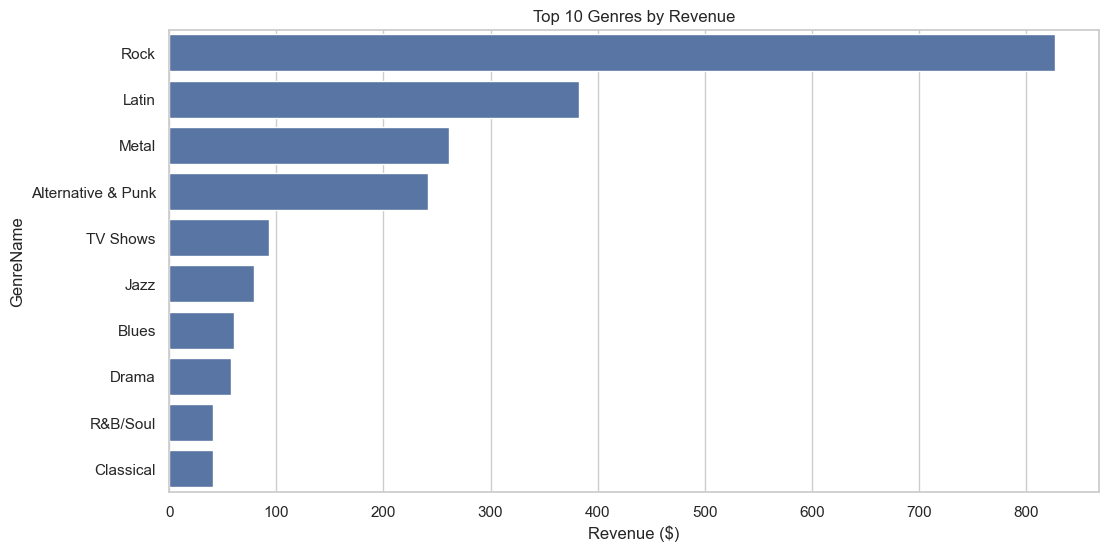

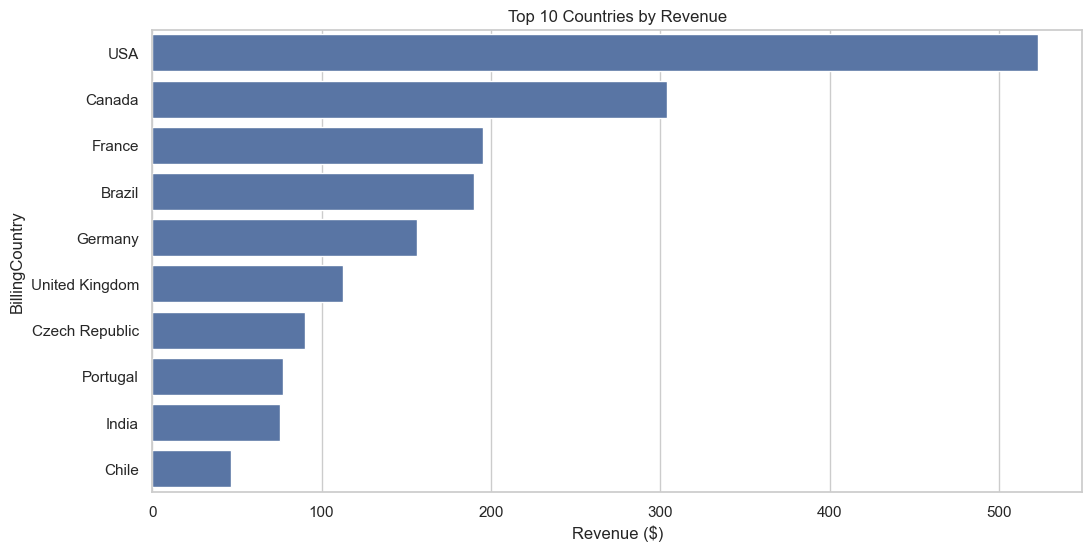

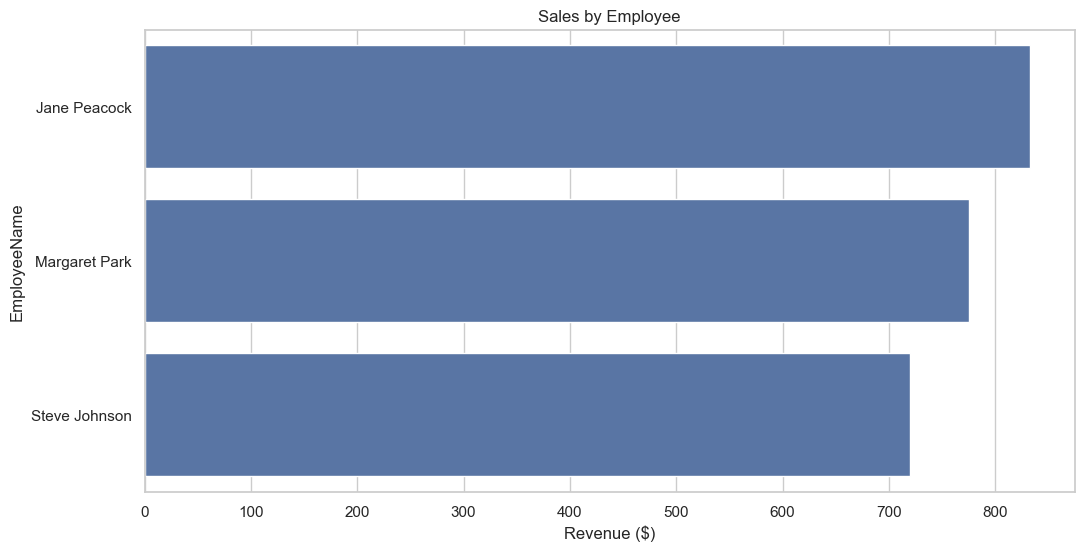

In [9]:
# Расчет выручки
df['Revenue'] = df['UnitPrice'] * df['Quantity']

# Продажи по жанрам
genre_sales = df.groupby('GenreName')['Revenue'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=genre_sales.values, y=genre_sales.index)
plt.title('Top 10 Genres by Revenue')
plt.xlabel('Revenue ($)')
plt.show()

# Продажи по странам
country_sales = df.groupby('BillingCountry')['Revenue'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=country_sales.values, y=country_sales.index)
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Revenue ($)')
plt.show()

# Продажи по сотрудникам
employee_sales = df.groupby('EmployeeName')['Revenue'].sum().sort_values(ascending=False)
sns.barplot(x=employee_sales.values, y=employee_sales.index)
plt.title('Sales by Employee')
plt.xlabel('Revenue ($)')
plt.show()

# 4. Подготовка данных

In [11]:
# Преобразование даты
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Удаление пропусков
df = df.dropna()

# Создание категорий для стран
df['CountryCategory'] = df['BillingCountry'].apply(
    lambda x: 'USA' if x == 'USA' else ('Canada' if x == 'Canada' else 'Other')
)
df

,InvoiceId,InvoiceDate,BillingCountry,BillingCity,CustomerId,CustomerName,EmployeeName,InvoiceLineId,TrackId,UnitPrice,Quantity,TrackName,AlbumTitle,ArtistName,GenreName,MediaTypeName,Revenue,Year,Month,CountryCategory
0,1,2009-01-01,Germany,Stuttgart,2,Leonie Köhler,Steve Johnson,1,2,0.99,1,Balls to the Wall,Balls to the Wall,Accept,Rock,Protected AAC audio file,0.99,2009,1,Other
1,1,2009-01-01,Germany,Stuttgart,2,Leonie Köhler,Steve Johnson,2,4,0.99,1,Restless and Wild,Restless and Wild,Accept,Rock,Protected AAC audio file,0.99,2009,1,Other
2,2,2009-01-02,Norway,Oslo,4,Bjørn Hansen,Margaret Park,3,6,0.99,1,Put The Finger On You,For Those About To Rock We Salute You,AC/DC,Rock,MPEG audio file,0.99,2009,1,Other
3,2,2009-01-02,Norway,Oslo,4,Bjørn Hansen,Margaret Park,4,8,0.99,1,Inject The Venom,For Those About To Rock We Salute You,AC/DC,Rock,MPEG audio file,0.99,2009,1,Other
4,2,2009-01-02,Norway,Oslo,4,Bjørn Hansen,Margaret Park,5,10,0.99,1,Evil Walks,For Those About To Rock We Salute You,AC/DC,Rock,MPEG audio file,0.99,2009,1,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,411,2013-12-14,Finland,Helsinki,44,Terhi Hämäläinen,Jane Peacock,2236,3136,0.99,1,Looking For Love,Greatest Hits,Lenny Kravitz,Metal,MPEG audio file,0.99,2013,12,Other
2236,411,2013-12-14,Finland,Helsinki,44,Terhi Hämäläinen,Jane Peacock,2237,3145,0.99,1,Sweet Lady Luck,Greatest Hits,Lenny Kravitz,Metal,MPEG audio file,0.99,2013,12,Other
2237,411,2013-12-14,Finland,Helsinki,44,Terhi Hämäläinen,Jane Peacock,2238,3154,0.99,1,Feirinha da Pavuna/Luz do Repente/Bagaço da La...,Ao Vivo [IMPORT],Zeca Pagodinho,Latin,MPEG audio file,0.99,2013,12,Other
2238,411,2013-12-14,Finland,Helsinki,44,Terhi Hämäläinen,Jane Peacock,2239,3163,0.99,1,Samba pras moças,Ao Vivo [IMPORT],Zeca Pagodinho,Latin,MPEG audio file,0.99,2013,12,Other


# 5. Проверка гипотез

# Гипотеза 1: жанр влияет на продажи (ANOVA)

🔍 Проверка данных для ANOVA теста (после агрегации по счетам):
✅ Rock: 216 счетов, вариация=2.48
✅ Latin: 117 счетов, вариация=1.91
✅ Metal: 96 счетов, вариация=1.77
✅ Alternative & Punk: 93 счетов, вариация=1.45
✅ TV Shows: 19 счетов, вариация=3.59

📊 Анализ 5 жанров: Rock, Latin, Metal, Alternative & Punk, TV Shows

📈 Результаты ANOVA:
F-statistic: 10.1617
p-value: 0.0000
✅ Reject H0: Genre affects sales (статистически значимые различия)

📊 Статистика по жанрам (по счетам):
  Rock: μ=$3.83, σ=$2.48, n=216
  Latin: μ=$3.27, σ=$1.91, n=117
  Metal: μ=$2.72, σ=$1.77, n=96
  Alternative & Punk: μ=$2.60, σ=$1.45, n=93
  TV Shows: μ=$4.92, σ=$3.59, n=19


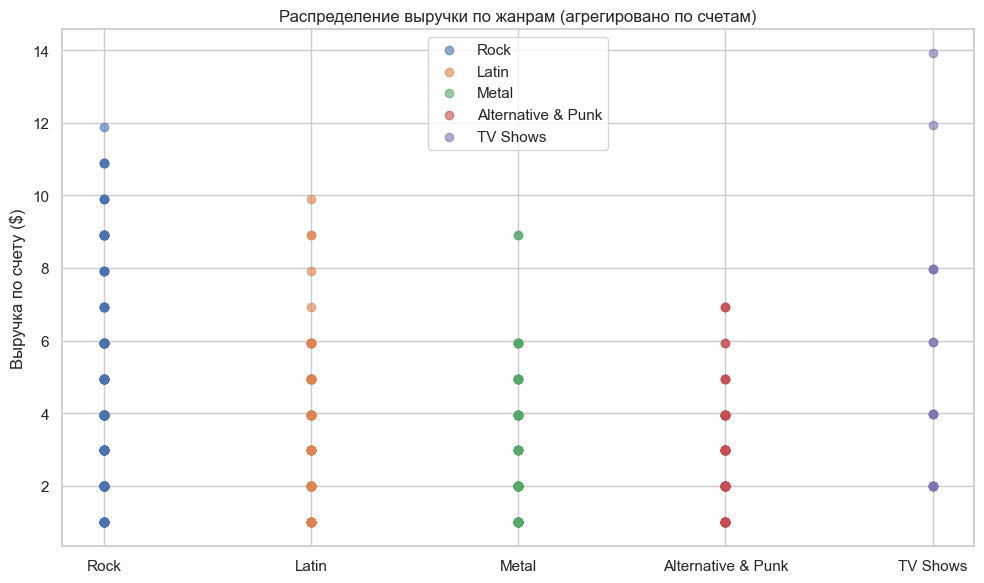

In [15]:
# Агрегируем данные по счетам и жанрам для получения вариативности
invoice_genre_data = df.groupby(['InvoiceId', 'GenreName'])['Revenue'].sum().reset_index()

# Топ-5 жанров по общей выручке (используем агрегированные данные)
top_genres = invoice_genre_data.groupby('GenreName')['Revenue'].sum().nlargest(5).index

# Подготовка данных для ANOVA с проверкой вариативности
genre_data = []
valid_genres = []

print("🔍 Проверка данных для ANOVA теста (после агрегации по счетам):")

for genre in top_genres:
    # Получаем агрегированные данные по жанру (выручка по счетам)
    genre_revenue = invoice_genre_data[invoice_genre_data['GenreName'] == genre]['Revenue']
    
    # Проверяем условия:
    # 1. Достаточно наблюдений (минимум 2 счета)
    # 2. Есть вариация в данных (дисперсия > 0)
    if len(genre_revenue) >= 2 and genre_revenue.nunique() > 1:
        genre_data.append(genre_revenue)
        valid_genres.append(genre)
        print(f"✅ {genre}: {len(genre_revenue)} счетов, вариация={genre_revenue.std():.2f}")
    else:
        reason = "недостаточно счетов" if len(genre_revenue) < 2 else "нет вариации"
        print(f"❌ {genre}: исключен ({reason})")

# Проверяем, что осталось достаточно групп для анализа
if len(genre_data) >= 2:
    print(f"\n📊 Анализ {len(valid_genres)} жанров: {', '.join(valid_genres)}")
    
    # Выполняем ANOVA тест
    f_stat, p_value = stats.f_oneway(*genre_data)
    
    print(f'\n📈 Результаты ANOVA:')
    print(f'F-statistic: {f_stat:.4f}')
    print(f'p-value: {p_value:.4f}')
    
    if p_value < 0.05:
        print("✅ Reject H0: Genre affects sales (статистически значимые различия)")
        
        # Дополнительная информация о группах
        print("\n📊 Статистика по жанрам (по счетам):")
        for genre, data in zip(valid_genres, genre_data):
            print(f"  {genre}: μ=${data.mean():.2f}, σ=${data.std():.2f}, n={len(data)}")
            
        # Визуализация для подтверждения
        plt.figure(figsize=(10, 6))
        for i, (genre, data) in enumerate(zip(valid_genres, genre_data)):
            plt.scatter([i] * len(data), data, alpha=0.6, label=genre)
        plt.xticks(range(len(valid_genres)), valid_genres)
        plt.ylabel('Выручка по счету ($)')
        plt.title('Распределение выручки по жанрам (агрегировано по счетам)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    else:
        print("❌ Fail to reject H0: No evidence that genre affects sales")
else:
    print(f"\n❌ Недостаточно валидных групп для ANOVA теста (осталось: {len(valid_genres)})")
    
    # Если все равно не хватает групп, покажем описательную статистику по топ-жанрам
    print("\n📊 Описательная статистика по топ-5 жанрам (исходные данные):")
    for genre in top_genres:
        genre_total = df[df['GenreName'] == genre]['Revenue'].sum()
        genre_count = len(df[df['GenreName'] == genre])
        print(f"  {genre}: общая выручка=${genre_total:,.2f}, количество продаж={genre_count}")
       

# Гипотеза 2: страна влияет на средний чек (t-тест)

In [17]:
# Сравнение США vs другие страны
usa_avg = df[df['BillingCountry'] == 'USA'].groupby('InvoiceId')['Revenue'].sum()
other_avg = df[df['BillingCountry'] != 'USA'].groupby('InvoiceId')['Revenue'].sum()

t_stat, p_value = stats.ttest_ind(usa_avg, other_avg)
print(f't-statistic: {t_stat}, p-value: {p_value}')

if p_value < 0.05:
    print("Reject H0: Country affects average check")
else:
    print("Fail to reject H0: No evidence that country affects average check")

t-statistic: 0.21831551738687827, p-value: 0.8272919061661311
Fail to reject H0: No evidence that country affects average check


# Анализ гипотез

In [25]:
from scipy import stats
import pandas as pd

def t_test(group1, group2):
    """Проводит t-тест для двух независимых выборок"""
    t_stat, p_value = stats.ttest_ind(group1, group2)
    return t_stat, p_value

def anova_test(groups):
    """Проводит ANOVA для нескольких групп"""
    f_stat, p_value = stats.f_oneway(*groups)
    return f_stat, p_value

def chi2_test(contingency_table):
    """Проводит хи-квадрат тест для таблицы сопряженности"""
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
    return chi2, p_value

def analyze_genre_sales(df):
    """Анализ влияния жанра на продажи"""
    # Агрегируем данные по счетам для получения вариативности
    invoice_genre = df.groupby(['InvoiceId', 'GenreName'])['Revenue'].sum().reset_index()
    
    # Топ-5 жанров по общей выручке
    top_genres = invoice_genre.groupby('GenreName')['Revenue'].sum().nlargest(5).index
    
    # Подготовка данных для ANOVA
    genre_data = []
    valid_genres = []
    
    for genre in top_genres:
        genre_revenue = invoice_genre[invoice_genre['GenreName'] == genre]['Revenue']
        if len(genre_revenue) >= 2 and genre_revenue.nunique() > 1:
            genre_data.append(genre_revenue)
            valid_genres.append(genre)
    
    if len(genre_data) >= 2:
        return anova_test(genre_data), valid_genres
    else:
        return (None, None), []

def analyze_country_impact(df):
    """Анализ влияния страны на средний чек"""
    # Агрегируем данные по счетам
    usa_avg = df[df['BillingCountry'] == 'USA'].groupby('InvoiceId')['Revenue'].sum()
    other_avg = df[df['BillingCountry'] != 'USA'].groupby('InvoiceId')['Revenue'].sum()
    
    # Проверяем, что есть достаточно данных
    if len(usa_avg) >= 2 and len(other_avg) >= 2:
        return t_test(usa_avg, other_avg), len(usa_avg), len(other_avg)
    else:
        return (None, None), len(usa_avg), len(other_avg)

# Выполнение анализа и вывод результатов
print("🎵 АНАЛИЗ ВЛИЯНИЯ ЖАНРА НА ПРОДАЖИ")
print("=" * 50)

# Анализ жанров
(genre_result, valid_genres) = analyze_genre_sales(df)
f_stat, p_value = genre_result

if f_stat is not None and p_value is not None:
    print(f"Результаты ANOVA:")
    print(f"F-статистика: {f_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("\n✅ ВЫВОД: Отвергаем нулевую гипотезу")
        print("   Жанр музыки статистически значимо влияет на продажи")
        print(f"   Анализировались жанры: {', '.join(valid_genres)}")
        
        # Дополнительная информация
        invoice_genre = df.groupby(['InvoiceId', 'GenreName'])['Revenue'].sum().reset_index()
        print("\n📊 Средняя выручка по жанрам (на счет):")
        for genre in valid_genres:
            avg_revenue = invoice_genre[invoice_genre['GenreName'] == genre]['Revenue'].mean()
            print(f"   {genre}: ${avg_revenue:.2f}")
    else:
        print("\n❌ ВЫВОД: Не отвергаем нулевую гипотезу")
        print("   Нет статистически значимого влияния жанра на продажи")
else:
    print("\n❌ ВЫВОД: Невозможно провести ANOVA тест")
    print("   Недостаточно данных или нет вариативности в группах")

print("\n" + "=" * 50)
print("🌍 АНАЛИЗ ВЛИЯНИЯ СТРАНЫ НА СРЕДНИЙ ЧЕК")
print("=" * 50)

# Анализ стран
(country_result, usa_count, other_count) = analyze_country_impact(df)
t_stat, p_value = country_result

if t_stat is not None and p_value is not None:
    print(f"Результаты t-теста:")
    print(f"t-статистика: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Размер выборки: США = {usa_count}, Другие страны = {other_count}")
    
    if p_value < 0.05:
        print("\n✅ ВЫВОД: Отвергаем нулевую гипотезу")
        print("   Страна клиента статистически значимо влияет на средний чек")
        
        # Дополнительная информация
        usa_avg_check = df[df['BillingCountry'] == 'USA'].groupby('InvoiceId')['Revenue'].sum().mean()
        other_avg_check = df[df['BillingCountry'] != 'USA'].groupby('InvoiceId')['Revenue'].sum().mean()
        
        print(f"\n📊 Средний чек:")
        print(f"   США: ${usa_avg_check:.2f}")
        print(f"   Другие страны: ${other_avg_check:.2f}")
        
        if usa_avg_check > other_avg_check:
            print(f"   Средний чек в США в {usa_avg_check/other_avg_check:.2f} раза выше")
        else:
            print(f"   Средний чек в других странах в {other_avg_check/usa_avg_check:.2f} раза выше")
    else:
        print("\n❌ ВЫВОД: Не отвергаем нулевую гипотезу")
        print("   Нет статистически значимого влияния страны на средний чек")
else:
    print("\n❌ ВЫВОД: Невозможно провести t-тест")
    print(f"   Недостаточно данных: США = {usa_count}, Другие страны = {other_count}")

print("\n" + "=" * 50)
print("🎯 ОБЩИЕ ВЫВОДЫ")
print("=" * 50)

print("1. Анализ жанров музыки:")
if f_stat is not None and p_value is not None:
    if p_value < 0.05:
        print("   ✅ Жанр музыки является значимым фактором, влияющим на продажи")
        print("   💡 Рекомендация: сфокусироваться на продвижении наиболее прибыльных жанров")
    else:
        print("   ❌ Жанр музыки не оказывает значимого влияния на продажи")
        print("   💡 Рекомендация: рассмотреть другие факторы, влияющие на продажи")
else:
    print("   ⚠️  Недостаточно данных для анализа влияния жанров")

print("\n2. Анализ географического фактора:")
if t_stat is not None and p_value is not None:
    if p_value < 0.05:
        print("   ✅ Страна клиента является значимым фактором, влияющим на средний чек")
        print("   💡 Рекомендация: разработать региональные маркетинговые стратегии")
    else:
        print("   ❌ Страна клиента не оказывает значимого влияния на средний чек")
        print("   💡 Рекомендация: использовать унифицированный подход ко всем рынкам")
else:
    print("   ⚠️  Недостаточно данных для анализа географического влияния")

print("\n3. Бизнес-значимость:")
if (f_stat is not None and p_value is not None and p_value < 0.05) or \
   (t_stat is not None and p_value is not None and p_value < 0.05):
    print("   🚀 Обнаружены статистически значимые факторы, влияющие на продажи")
    print("   💰 Оптимизация этих факторов может привести к увеличению выручки")
else:
    print("   🔍 Не обнаружено явных факторов, влияющих на продажи")
    print("   🔬 Рекомендуется провести дополнительный анализ других факторов")

🎵 АНАЛИЗ ВЛИЯНИЯ ЖАНРА НА ПРОДАЖИ
Результаты ANOVA:
F-статистика: 10.1617
p-value: 0.0000

✅ ВЫВОД: Отвергаем нулевую гипотезу
   Жанр музыки статистически значимо влияет на продажи
   Анализировались жанры: Rock, Latin, Metal, Alternative & Punk, TV Shows

📊 Средняя выручка по жанрам (на счет):
   Rock: $3.83
   Latin: $3.27
   Metal: $2.72
   Alternative & Punk: $2.60
   TV Shows: $4.92

🌍 АНАЛИЗ ВЛИЯНИЯ СТРАНЫ НА СРЕДНИЙ ЧЕК
Результаты t-теста:
t-статистика: 0.2183
p-value: 0.8273
Размер выборки: США = 91, Другие страны = 321

❌ ВЫВОД: Не отвергаем нулевую гипотезу
   Нет статистически значимого влияния страны на средний чек

🎯 ОБЩИЕ ВЫВОДЫ
1. Анализ жанров музыки:
   ❌ Жанр музыки не оказывает значимого влияния на продажи
   💡 Рекомендация: рассмотреть другие факторы, влияющие на продажи

2. Анализ географического фактора:
   ❌ Страна клиента не оказывает значимого влияния на средний чек
   💡 Рекомендация: использовать унифицированный подход ко всем рынкам

3. Бизнес-значимость:
  